In [1]:
%load_ext autoreload
%autoreload 2

import os

subjects = list(range(1, 31, 1))

exp = "exp_reduced_flow"
root = "reduced_flow/analysis"
os.makedirs(root, exist_ok = True)

In [2]:
import numpy
import pandas
import IPython.display
import matplotlib.pyplot as plt

import SDA.analytics
import SDA.clustquality

### Results

In [3]:
class Results:
    def __init__(self, features_type: str):
        self.lengths: list = [ ]
        self.num_features: list = [ ]
        self.explained_variances: list = [ ]
        self.n_stages: list = [ ]
        self.silhouettes: list = [ ]
        self.fmis: list = [ ]

        for subject_num in subjects:
            subj = f"phase2/Subj{subject_num}"

            all_features_shape = numpy.loadtxt(f"{subj}/{exp}/results/{features_type}/all_features_shape.txt")
            self.num_features.append(all_features_shape[1])
            self.lengths.append(all_features_shape[0])
            
            explained_variance = numpy.loadtxt(f"{subj}/{exp}/results/{features_type}/explained_variance.txt")
            self.explained_variances.append(explained_variance)
            
            best_edges = numpy.loadtxt(f"{subj}/{exp}/results/{features_type}/best_edges.txt").astype(numpy.uint32)
            self.n_stages.append(len(best_edges))

            best_result = pandas.read_csv(f"{subj}/{exp}/results/{features_type}/best_result.csv").iloc[0].to_dict()
            self.silhouettes.append(best_result["Avg-Silh"])

            trad_best_edges = numpy.loadtxt(f"{subj}/{exp}/results/traditional/best_edges.txt").astype(numpy.uint32)
            assert len(best_edges) == len(trad_best_edges)
            self.fmis.append(SDA.clustquality.cluster_metrics_ground(trad_best_edges, best_edges, [ "FMI" ])["FMI"])

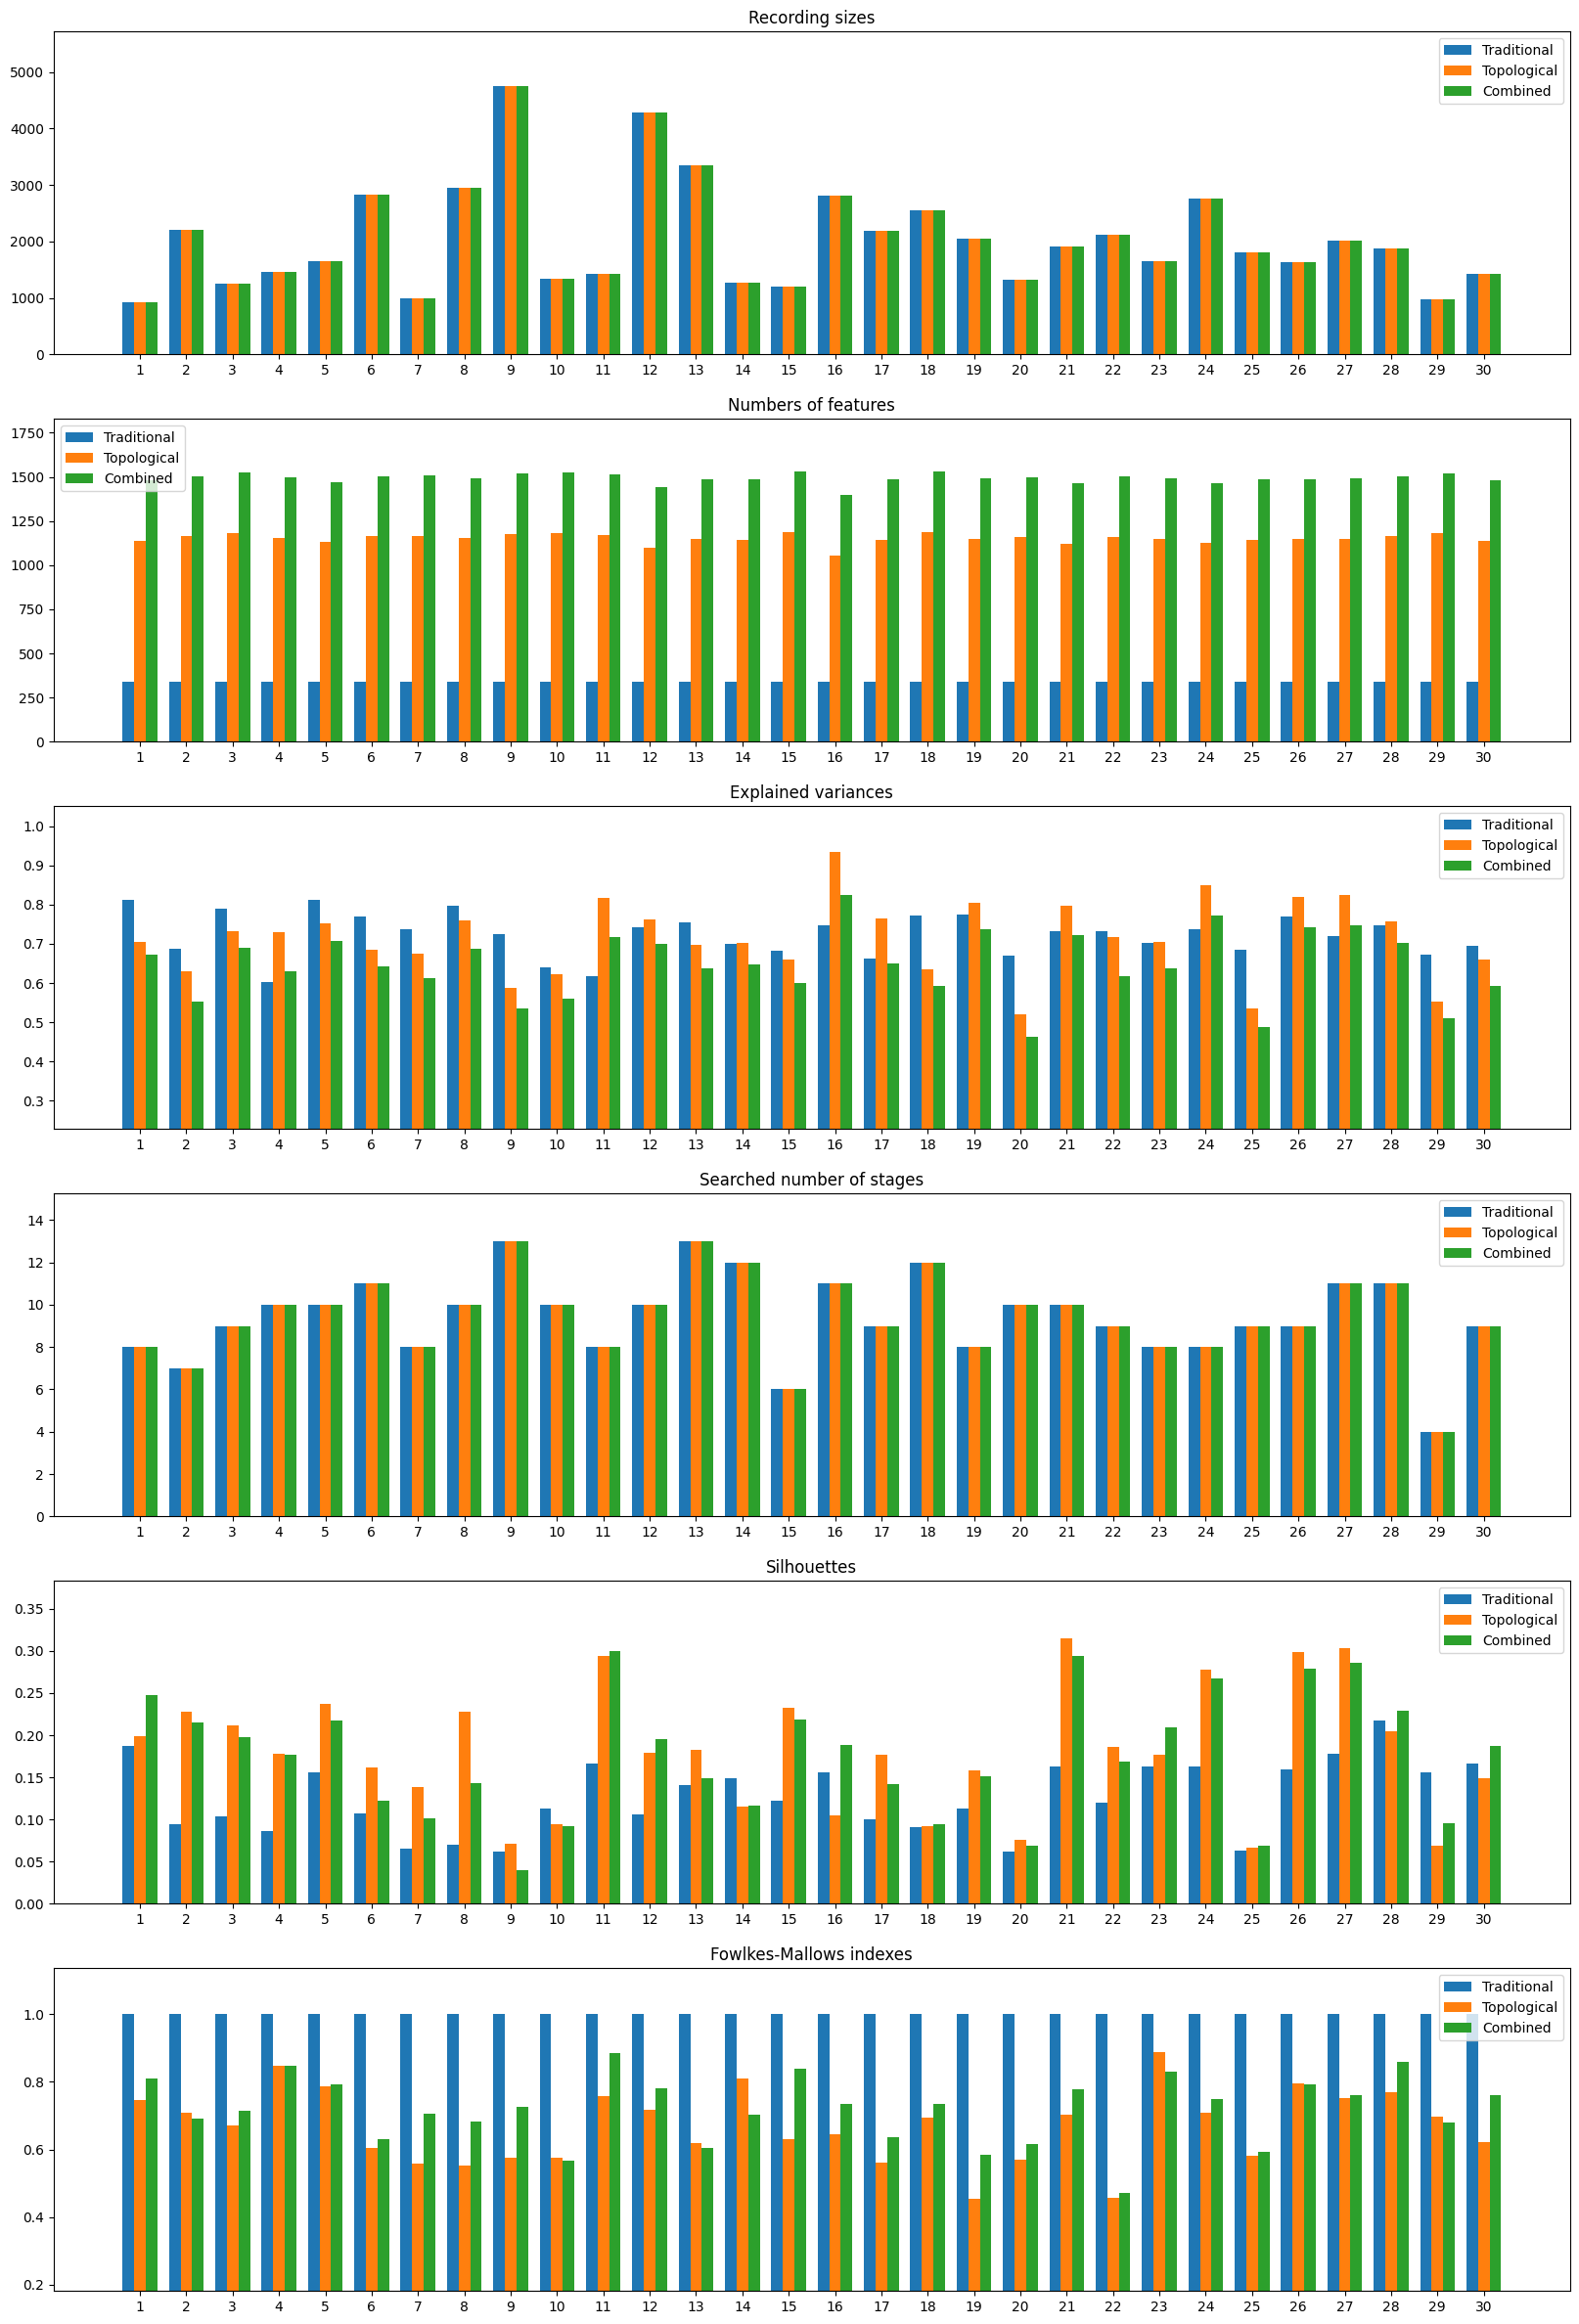

In [8]:
traditional = Results("traditional")
topological = Results("best_topological")
combined = Results("combined")

fig, axes = plt.subplots(6, 1, figsize = (20, 30))
WIDTH = 0.25
ROTATION = 45

def draw(ax, x: list, traditional: list, topological: list, combined: list, title: str):
    mini = numpy.min([ *traditional, *topological, *combined ])
    maxi = numpy.max([ *traditional, *topological, *combined ])
    ax.set_ylim(max(mini - (maxi - mini) / 2, 0), maxi + (maxi - mini) / 4)

    x = numpy.array(subjects)
    ax.bar(x, traditional, width = WIDTH, label = 'Traditional')
    ax.bar(x + WIDTH, topological, width = WIDTH, label = 'Topological')
    ax.bar(x + 2 * WIDTH, combined, width = WIDTH, label = 'Combined')
    ax.set_xticks(x + WIDTH, x)
    ax.set_title(title)
    ax.legend()

draw(axes.flat[0], subjects, traditional.lengths, topological.lengths, combined.lengths, "Recording sizes")
draw(axes.flat[1], subjects, traditional.num_features, topological.num_features, combined.num_features, "Numbers of features")
draw(axes.flat[2], subjects, traditional.explained_variances, topological.explained_variances, combined.explained_variances, "Explained variances")
draw(axes.flat[3], subjects, traditional.n_stages, topological.n_stages, combined.n_stages, "Searched number of stages")
draw(axes.flat[4], subjects, traditional.silhouettes, topological.silhouettes, combined.silhouettes, "Silhouettes")
draw(axes.flat[5], subjects, traditional.fmis, topological.fmis, combined.fmis, "Fowlkes-Mallows indexes")

fig.savefig(f"{root}/results.svg")
fig.savefig(f"{root}/results.png")

### IV

In [5]:
class ScoresResults:
    def __init__(self, stats_type: str):
        self.by_source = [ ]

        for subject_num in subjects:
            subj = f"phase2/Subj{subject_num}"

            stats_by_source = pandas.read_csv(f"{subj}/{exp}/IV/stats_Source_{stats_type}.csv")[["Source", stats_type]]
            stats_by_source = stats_by_source.rename(columns = { stats_type: subj }).set_index("Source")
            self.by_source.append(stats_by_source)
    
        self.by_source: pandas.DataFrame = pandas.concat(self.by_source, axis = 1).reset_index()

def draw_sources_heatmap(by_score: pandas.DataFrame, name: str):
    by_score = by_score[by_score.apply(lambda row: row['Source'].startswith('channel-'), axis = 1)]
    scores_src = by_score.mean(axis = 1, numeric_only = True)
    ids = by_score["Source"]

    scores = numpy.zeros(38)
    for id, score in zip(ids, scores_src):
        id = int(id[id.find('-') + 1:])
        scores[id] = score

    svg = SDA.analytics.draw_sources_heatmap(scores)
    file = f"{root}/{name}_regions.svg"
    open(file, "w").write(svg)
    return IPython.display.SVG(file)

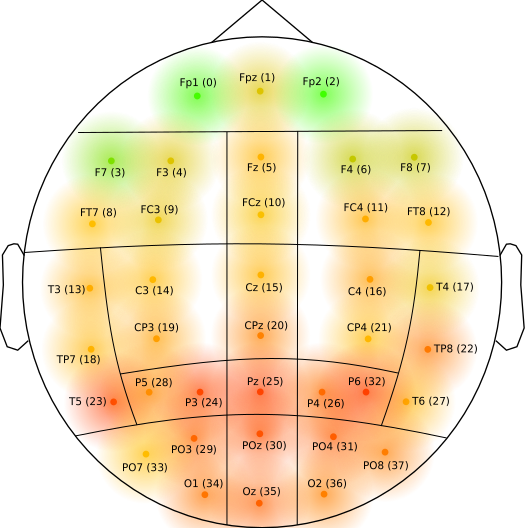

In [6]:
draw_sources_heatmap(ScoresResults("IV").by_source, "IV")

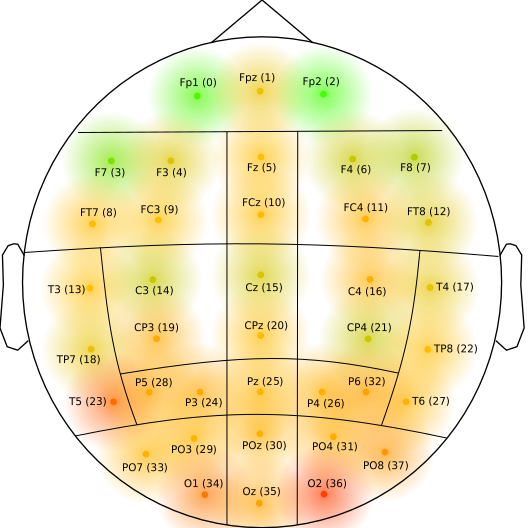

In [7]:
draw_sources_heatmap(ScoresResults("score").by_source, "score")